# Healthy Pathway Score Calculation



In [2]:
!pip install scanpy anndata pandas scikit-learn matplotlib seaborn loompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=5f213b218dc55c1b0b33babe73d3a3749e5e2c26f658a1ea6e00e3399065a492
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=d7d205

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scanpy as sc
import numpy as np

h5ad_path_healthy = "/content/drive/MyDrive/Colab Notebooks/Final_Pres_normalised_count.h5ad"
adata_healthy = sc.read_h5ad(h5ad_path_healthy)
adata_healthy = adata_healthy.transpose()

In [5]:
print(adata_healthy.X[:5, :5].toarray())

[[  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [  0.       0.     636.1324   0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]]


In [6]:
print(adata_healthy.var.head())

Empty DataFrame
Columns: []
Index: [ENSG00000000003, ENSG00000000419, ENSG00000000457, ENSG00000000460, ENSG00000000938]


In [7]:
print(adata_healthy.obs.head())

Empty DataFrame
Columns: []
Index: [SRR8942434-AAAACACACTGG, SRR8942434-AAAACCGCTGGT, SRR8942434-AAAATGCTTTCT, SRR8942434-AAAATTCCGCAC, SRR8942434-AAAGGACACGAG]


In [ ]:
# Correct summing and normalization
# Adding a small constant (epsilon) to avoid division by zero
epsilon = 1e-6
gene_sums_healthy = adata_healthy.X.sum(axis=0)  # Sum across cells for each gene
gene_cell_counts_healthy = (adata_healthy.X > 0).sum(axis=0)  # Count cells where each gene is expressed

safe_gene_cell_counts_healthy = np.where(gene_cell_counts_healthy == 0, epsilon, gene_cell_counts_healthy)

normalized_gene_expression_healthy = gene_sums_healthy / safe_gene_cell_counts_healthy

# Check for NaN values and fill them if necessary
normalized_gene_expression_healthy = np.nan_to_num(normalized_gene_expression_healthy, nan=0.0)

In [ ]:
import pandas as pd
import scipy.sparse as sp

# Load the gene-pathway mapping and drop rows with NaN in 'Ensembl Gene ID'
gene_pathway_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gene_pathway_single.csv")
gene_pathway_df = gene_pathway_df.dropna(subset=['Ensembl Gene ID'])

gene_pathway_df = gene_pathway_df.copy()
# Ensure the 'Ensembl Gene ID' column is of type string, if necessary
gene_pathway_df['Ensembl Gene ID'] = gene_pathway_df['Ensembl Gene ID'].astype(str)

common_genes = set(gene_pathway_df['Ensembl Gene ID']).intersection(set(adata_healthy.var_names))
print("Number of matching genes:", len(common_genes))

# Debugging: Check if any gene IDs are empty or not matching
print("Number of gene IDs in gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].nunique())
print("Sample gene IDs from gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].dropna().unique()[:5])
print("Sample gene IDs from adata:", adata_healthy.var_names.dropna().unique()[:5])


# Initialize an empty dataframe to hold the PAS
pathway_activity_scores_healthy = pd.DataFrame(0, index=adata_healthy.obs_names, columns=gene_pathway_df['Pathway ID'].unique())

# Loop over each pathway to calculate scores
for pathway_id in pathway_activity_scores_healthy.columns:
    # Get the genes for this pathway
    pathway_genes = gene_pathway_df[gene_pathway_df['Pathway ID'] == pathway_id]['Ensembl Gene ID']

    # Debugging: Check if pathway_genes is not empty
    # print(f"Pathway ID: {pathway_id}, Genes in pathway: {pathway_genes.values}")

    # Find the indices of these genes in `adata.var_names`
    gene_indices = [np.where(adata_healthy.var_names == gene_id)[0][0] for gene_id in pathway_genes if gene_id in adata_healthy.var_names and np.where(adata_healthy.var_names == gene_id)[0].size > 0]

    # Debugging: Check the gene indices
    # print(f"Gene indices for pathway {pathway_id}: {gene_indices}")

    # If the pathway has no genes, skip to the next pathway
    if not gene_indices:
        print(f"No genes found for pathway {pathway_id}")
        continue

    # Extract the expression data for these genes
    if sp.issparse(adata_healthy.X):
        pathway_data = adata_healthy.X[:, gene_indices].toarray()
    else:
        pathway_data = adata_healthy.X[:, gene_indices]

    # Debugging: Check the summed data before normalization
    pathway_sum = pathway_data.sum(axis=1)
    # print(f"Pathway sum before normalization for {pathway_id}: {pathway_sum}")

    # Sum and normalize the data across the genes to get total pathway activity
    normalized_scores = pathway_sum / len(gene_indices)
    pathway_activity_scores_healthy[pathway_id] = normalized_scores

    # Debugging: Check for non-zero scores
    non_zero_scores = normalized_scores[np.nonzero(normalized_scores)]
    # print(f"Non-zero scores for pathway {pathway_id}: {non_zero_scores}")

# Check if `pathway_activity_scores` DataFrame contains non-zero values
# print("Non-zero scores in pathway_activity_scores:")
# print(pathway_activity_scores[pathway_activity_scores > 0].dropna(how='all', axis=1))

print(pathway_activity_scores_healthy.head(5))


Number of matching genes: 6726
Number of gene IDs in gene_pathway_df: 8605
Sample gene IDs from gene_pathway_df: ['ENSG00000160883' 'ENSG00000156515' 'ENSG00000159399' 'ENSG00000156510'
 'ENSG00000106633']
Sample gene IDs from adata: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000000938'],
      dtype='object')
                           hsa00010    hsa00020    hsa00030   hsa00040  \
SRR8942434-AAAACACACTGG   46.339205   22.311469   23.169603   0.000000   
SRR8942434-AAAACCGCTGGT  221.375246   37.074115  288.750323   0.000000   
SRR8942434-AAAATGCTTTCT  134.566467  129.582526  110.099838  58.901148   
SRR8942434-AAAATTCCGCAC  153.813769    0.000000  275.245692   0.000000   
SRR8942434-AAAGGACACGAG   97.002615   93.409926   97.002615  46.704963   

                           hsa00051    hsa00052    hsa00053    hsa00500  \
SRR8942434-AAAACACACTGG   77.730279    0.000000   28.686175   21.514631   
SRR8942434-AAAACCGCTGGT  177.596974   8

In [ ]:
pathway_activity_scores_healthy.to_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores_healthy.csv")

# Cancer Pathway Score Calculation


In [8]:
import scanpy as sc
import numpy as np

h5ad_path_cancer = "/content/drive/MyDrive/Colab Notebooks/Cancer_filtered_normalised_count.h5ad"
adata_cancer = sc.read_h5ad(h5ad_path_cancer)
adata_cancer = adata_cancer.transpose()

In [ ]:
print(adata_cancer.X[:5, :5].toarray())

[[  0.        0.        0.        0.        0.     ]
 [337.72375 337.72375   0.        0.        0.     ]
 [  0.        0.        0.        0.        0.     ]
 [  0.        0.        0.        0.        0.     ]
 [  0.        0.        0.        0.        0.     ]]


In [ ]:
print(adata_cancer.var.head())

Empty DataFrame
Columns: []
Index: [ENSG00000000003, ENSG00000000419, ENSG00000000457, ENSG00000000460, ENSG00000000938]


In [ ]:
print(adata_cancer.obs.head())

Empty DataFrame
Columns: []
Index: [ERR2744030-AAAACCGCATATGA, ERR2744030-AAAACCGCATTCTC, ERR2744030-AAAACCGGTACTTG, ERR2744030-AAAACCGGTTGCCT, ERR2744030-AAAATGATCAAGAA]


In [ ]:
# Correct summing and normalization
# Adding a small constant (epsilon) to avoid division by zero
epsilon = 1e-6
gene_sums_cancer = adata_cancer.X.sum(axis=0)  # Sum across cells for each gene
gene_cell_counts_cancer = (adata_cancer.X > 0).sum(axis=0)  # Count cells where each gene is expressed

safe_gene_cell_counts_cancer = np.where(gene_cell_counts_cancer == 0, epsilon, gene_cell_counts_cancer)

normalized_gene_expression_cancer = gene_sums_cancer / safe_gene_cell_counts_cancer

# Check for NaN values and fill them if necessary
normalized_gene_expression_cancer = np.nan_to_num(normalized_gene_expression_cancer, nan=0.0)

In [ ]:
import pandas as pd
import scipy.sparse as sp

# Load the gene-pathway mapping and drop rows with NaN in 'Ensembl Gene ID'
gene_pathway_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gene_pathway_single.csv")
gene_pathway_df = gene_pathway_df.dropna(subset=['Ensembl Gene ID'])

gene_pathway_df = gene_pathway_df.copy()
# Ensure the 'Ensembl Gene ID' column is of type string, if necessary
gene_pathway_df['Ensembl Gene ID'] = gene_pathway_df['Ensembl Gene ID'].astype(str)

common_genes = set(gene_pathway_df['Ensembl Gene ID']).intersection(set(adata_cancer.var_names))
print("Number of matching genes:", len(common_genes))

# Debugging: Check if any gene IDs are empty or not matching
print("Number of gene IDs in gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].nunique())
print("Sample gene IDs from gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].dropna().unique()[:5])
print("Sample gene IDs from adata:", adata_cancer.var_names.dropna().unique()[:5])


# Initialize an empty dataframe to hold the PAS
pathway_activity_scores_cancer = pd.DataFrame(0, index=adata_cancer.obs_names, columns=gene_pathway_df['Pathway ID'].unique())

# Loop over each pathway to calculate scores
for pathway_id in pathway_activity_scores_cancer.columns:
    # Get the genes for this pathway
    pathway_genes = gene_pathway_df[gene_pathway_df['Pathway ID'] == pathway_id]['Ensembl Gene ID']

    # Debugging: Check if pathway_genes is not empty
    # print(f"Pathway ID: {pathway_id}, Genes in pathway: {pathway_genes.values}")

    # Find the indices of these genes in `adata.var_names`
    gene_indices = [np.where(adata_cancer.var_names == gene_id)[0][0] for gene_id in pathway_genes if gene_id in adata_cancer.var_names and np.where(adata_cancer.var_names == gene_id)[0].size > 0]

    # Debugging: Check the gene indices
    # print(f"Gene indices for pathway {pathway_id}: {gene_indices}")

    # If the pathway has no genes, skip to the next pathway
    if not gene_indices:
        print(f"No genes found for pathway {pathway_id}")
        continue

    # Extract the expression data for these genes
    if sp.issparse(adata_cancer.X):
        pathway_data = adata_cancer.X[:, gene_indices].toarray()
    else:
        pathway_data = adata_cancer.X[:, gene_indices]

    # Debugging: Check the summed data before normalization
    pathway_sum = pathway_data.sum(axis=1)
    # print(f"Pathway sum before normalization for {pathway_id}: {pathway_sum}")

    # Sum and normalize the data across the genes to get total pathway activity
    normalized_scores = pathway_sum / len(gene_indices)
    pathway_activity_scores_cancer[pathway_id] = normalized_scores

    # Debugging: Check for non-zero scores
    non_zero_scores = normalized_scores[np.nonzero(normalized_scores)]
    # print(f"Non-zero scores for pathway {pathway_id}: {non_zero_scores}")

# Check if `pathway_activity_scores` DataFrame contains non-zero values
# print("Non-zero scores in pathway_activity_scores:")
# print(pathway_activity_scores[pathway_activity_scores > 0].dropna(how='all', axis=1))

print(pathway_activity_scores_cancer.head(5))


Number of matching genes: 7507
Number of gene IDs in gene_pathway_df: 8605
Sample gene IDs from gene_pathway_df: ['ENSG00000160883' 'ENSG00000156515' 'ENSG00000159399' 'ENSG00000156510'
 'ENSG00000106633']
Sample gene IDs from adata: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000000938'],
      dtype='object')
                             hsa00010   hsa00020    hsa00030  hsa00040  \
ERR2744030-AAAACCGCATATGA  137.931053   0.000000  118.226617       0.0   
ERR2744030-AAAACCGCATTCTC  122.279288  24.123125   11.645647       0.0   
ERR2744030-AAAACCGGTACTTG  126.930403  87.642421    0.000000       0.0   
ERR2744030-AAAACCGGTTGCCT   20.949429   0.000000    0.000000       0.0   
ERR2744030-AAAATGATCAAGAA   46.953647  58.356675   37.562917       0.0   

                            hsa00051   hsa00052   hsa00053   hsa00500  \
ERR2744030-AAAACCGCATATGA  67.226900   0.000000   0.000000   0.000000   
ERR2744030-AAAACCGCATTCTC  49.665257  12.50

In [ ]:
pathway_activity_scores_cancer.to_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores_cancer.csv")

# Queries


In [ ]:
import pandas as pd

# Assuming `pathway_activity_scores` is a pandas DataFrame with cells as index and pathways as columns.

# Global Expression Level Queries
def query_global_expression(dataframe, threshold, query_type='high'):
    """
    Query cells with high or low total pathway activity scores.

    :param dataframe: DataFrame containing pathway activity scores.
    :param threshold: Threshold value for total pathway activity score.
    :param query_type: 'high' for high expression, 'low' for low expression.
    :return: DataFrame of cells that meet the query condition.
    """
    total_scores = dataframe.sum(axis=1)
    if query_type == 'high':
        return dataframe.loc[total_scores >= threshold]
    elif query_type == 'low':
        return dataframe.loc[total_scores <= threshold]

# Pathway-Specific Expression Queries
def query_pathway_specific(dataframe, pathway_id, threshold, query_type='above'):
    """
    Query cells based on the expression level of a specific pathway.

    :param dataframe: DataFrame containing pathway activity scores.
    :param pathway_id: Specific pathway ID to query.
    :param threshold: Threshold value for pathway activity score.
    :param query_type: 'above' for scores above the threshold, 'below' for scores below.
    :return: DataFrame of cells that meet the query condition.
    """
    if query_type == 'above':
        return dataframe.loc[dataframe[pathway_id] >= threshold]
    elif query_type == 'below':
        return dataframe.loc[dataframe[pathway_id] <= threshold]

# Co-Expression Queries
def coexpression_query(dataframe, pathways_list, threshold, mode='above'):
    """
    Enhanced query for co-expression, where pathways must be simultaneously above or below a threshold.

    :param dataframe: DataFrame containing pathway activity scores.
    :param pathways_list: List of pathways to query.
    :param threshold: Numerical threshold for pathway activity.
    :param mode: 'above' for activity above the threshold, 'below' for below the threshold.
    :return: DataFrame of cells that meet the co-expression criteria.
    """
    if mode == 'above':
        mask = (dataframe[pathways_list] > threshold).all(axis=1)
    else:
        mask = (dataframe[pathways_list] < threshold).all(axis=1)
    return dataframe[mask]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pathway_activity_scores_healthy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores_healthy.csv", index_col=0)
pathway_activity_scores_cancer = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores_cancer.csv", index_col=0)


In [ ]:
# Example of running a global expression level query for cells with high total pathway activity
high_activity_cells_healthy = query_global_expression(pathway_activity_scores_healthy, threshold=33000, query_type='high')
print("High Activity Cells Healthy:\n", high_activity_cells_healthy)

high_activity_cells_cancer = query_global_expression(pathway_activity_scores_cancer, threshold=33000, query_type='high')
print("High Activity Cells Cancer:\n", high_activity_cells_cancer)


High Activity Cells Healthy:
                            hsa00010    hsa00020    hsa00030   hsa00040  \
SRR8942434-AAAGTACATATA  222.893668   95.394821  123.829815   0.000000   
SRR8942434-ACAAGCTGTGTA  199.153604   95.888770  248.942008  47.944385   
SRR8942434-ACGGAATGCGCA  222.222263    0.000000  273.504324  32.921816   
SRR8942434-AGAACTTCAGAA   66.250694   69.596689  108.410227   0.000000   
SRR8942434-AGCCGAAAGCCC  190.208379  135.676759  126.805586   0.000000   
...                             ...         ...         ...        ...   
SRR8942436-TGTGCGGGTGCG   35.629033   68.618879    0.000000   0.000000   
SRR8942436-TGTTATGATCCG   99.583962    0.000000    0.000000   0.000000   
SRR8942436-TTCTAAAGGTAA   82.769625   86.949911   30.098046  28.983304   
SRR8942436-TTTAAGCCCGAT   75.844400   32.460156    0.000000   0.000000   
SRR8942436-TTTAGCCATTGC   88.434272   14.193155   88.434272   0.000000   

                           hsa00051    hsa00052    hsa00053   hsa00500  \
SRR8942

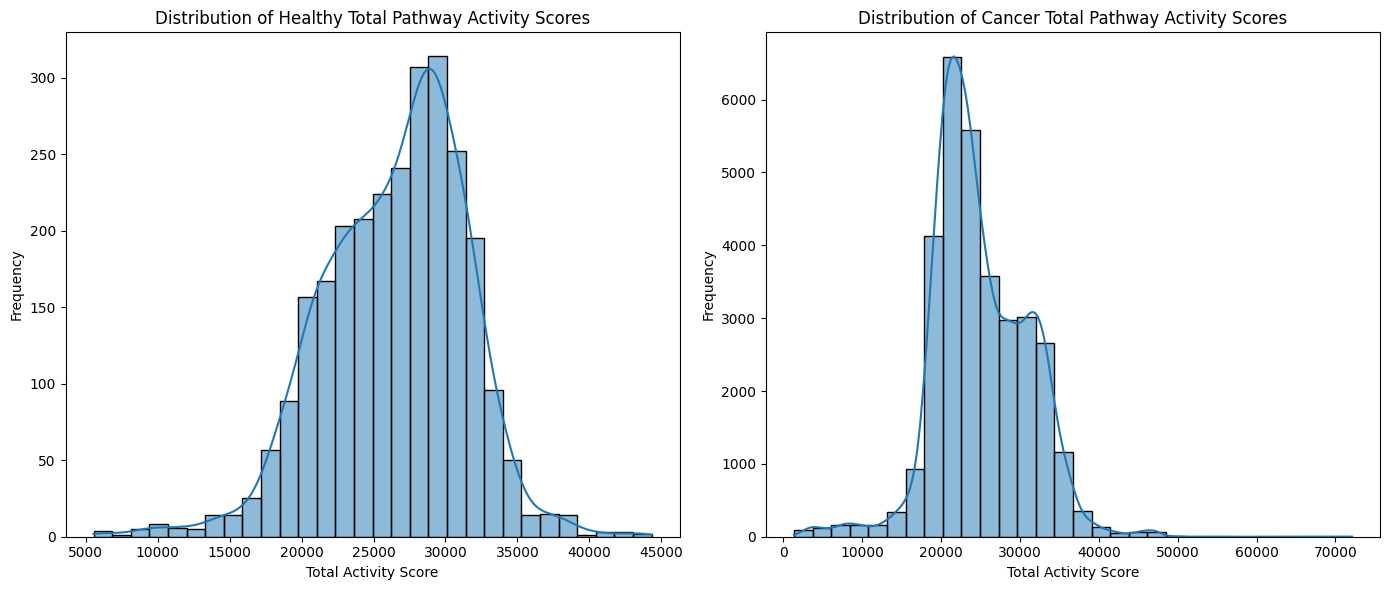

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total pathway activity scores for each cell
total_scores_healthy = pathway_activity_scores_healthy.sum(axis=1)
total_scores_cancer = pathway_activity_scores_cancer.sum(axis=1)

# Plotting both distributions side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotting healthy scores
sns.histplot(total_scores_healthy, bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Healthy Total Pathway Activity Scores')
axs[0].set_xlabel('Total Activity Score')
axs[0].set_ylabel('Frequency')

# Plotting cancer scores
sns.histplot(total_scores_cancer, bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Cancer Total Pathway Activity Scores')
axs[1].set_xlabel('Total Activity Score')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def analyze_activity_scores(pathway_activity_scores):
    # Calculate total pathway activity scores for each cell
    total_scores = pathway_activity_scores.sum(axis=1)

    # Define thresholds for high and low activity
    mean_score = np.mean(total_scores)
    std_score = np.std(total_scores)
    high_threshold = mean_score + std_score  # One standard deviation above the mean
    low_threshold = mean_score - std_score   # One standard deviation below the mean

    # Query for high activity cells
    high_activity_cells = pathway_activity_scores.loc[total_scores >= high_threshold]
    print("High Activity Cells:\n", high_activity_cells)

    # Query for low activity cells
    low_activity_cells = pathway_activity_scores.loc[total_scores <= low_threshold]
    print("Low Activity Cells:\n", low_activity_cells)

# Apply the function to the healthy and cancer data
print("Healthy Data Analysis:")
analyze_activity_scores(pathway_activity_scores_healthy)

print("\nCancer Data Analysis:")
analyze_activity_scores(pathway_activity_scores_cancer)

Healthy Data Analysis:
High Activity Cells:
                            hsa00010   hsa00020    hsa00030   hsa00040  \
SRR8942434-AAAGTACATATA  222.893668  95.394821  123.829815   0.000000   
SRR8942434-AACAGGCTCCCA  250.760933   0.000000  155.644719   0.000000   
SRR8942434-AATTAACATTCG  159.096326  76.601933   99.435204  19.150483   
SRR8942434-ACAAGCTGTGTA  199.153604  95.888770  248.942008  47.944385   
SRR8942434-ACACAAATAACT  139.759559  42.057275  139.759556  16.822910   
...                             ...        ...         ...        ...   
SRR8942436-TTCTAAAGGTAA   82.769625  86.949911   30.098046  28.983304   
SRR8942436-TTCTCTGTGCGG   77.543423  59.737156    0.000000  89.605733   
SRR8942436-TTGATTAGATTG  121.494046  33.426933   69.425169  66.853867   
SRR8942436-TTTAAGCCCGAT   75.844400  32.460156    0.000000   0.000000   
SRR8942436-TTTAGCCATTGC   88.434272  14.193155   88.434272   0.000000   

                           hsa00051    hsa00052    hsa00053   hsa00500  \
SRR8

In [ ]:
# Usage example for both healthy and cancer datasets
print("Healthy Data Analysis:")
specific_pathway_cells_healthy = query_pathway_specific(pathway_activity_scores_healthy, pathway_id='hsa00010', threshold=220, query_type='above')
print("Specific Pathway High Expression Cells in Healthy Data:\n", specific_pathway_cells_healthy)

print("\nCancer Data Analysis:")
specific_pathway_cells_cancer = query_pathway_specific(pathway_activity_scores_cancer, pathway_id='hsa00010', threshold=220, query_type='above')
print("Specific Pathway High Expression Cells in Cancer Data:\n", specific_pathway_cells_cancer)

Healthy Data Analysis:
Specific Pathway High Expression Cells in Healthy Data:
                            hsa00010   hsa00020    hsa00030   hsa00040  \
SRR8942434-AAAACCGCTGGT  221.375246  37.074115  288.750323   0.000000   
SRR8942434-AAAGTACATATA  222.893668  95.394821  123.829815   0.000000   
SRR8942434-AACAGGCTCCCA  250.760933   0.000000  155.644719   0.000000   
SRR8942434-ACGATTTCAACG  261.445515  74.596252  213.029677  74.596252   
SRR8942434-ACGGAATGCGCA  222.222263   0.000000  273.504324  32.921816   
...                             ...        ...         ...        ...   
SRR8942435-CTTCACGTAGTT  238.195329  26.985093  196.160858  26.985093   
SRR8942435-TATGAGTCCACG  300.480769   0.000000  120.192308  46.296296   
SRR8942436-ACTCGGCGCCAA  256.899590  47.120911   73.399881  47.120911   
SRR8942436-TAGACACTGAGC  223.613610  86.132652   44.722723   0.000000   
SRR8942436-TAGTGGCCCTAA  287.026413   0.000000   95.675469  46.065967   

                           hsa00051    hsa0

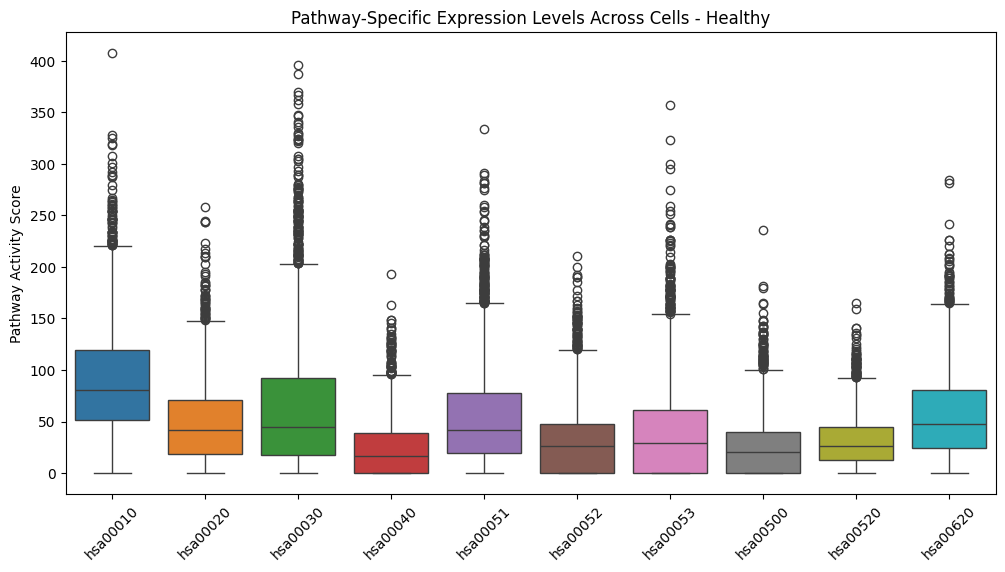

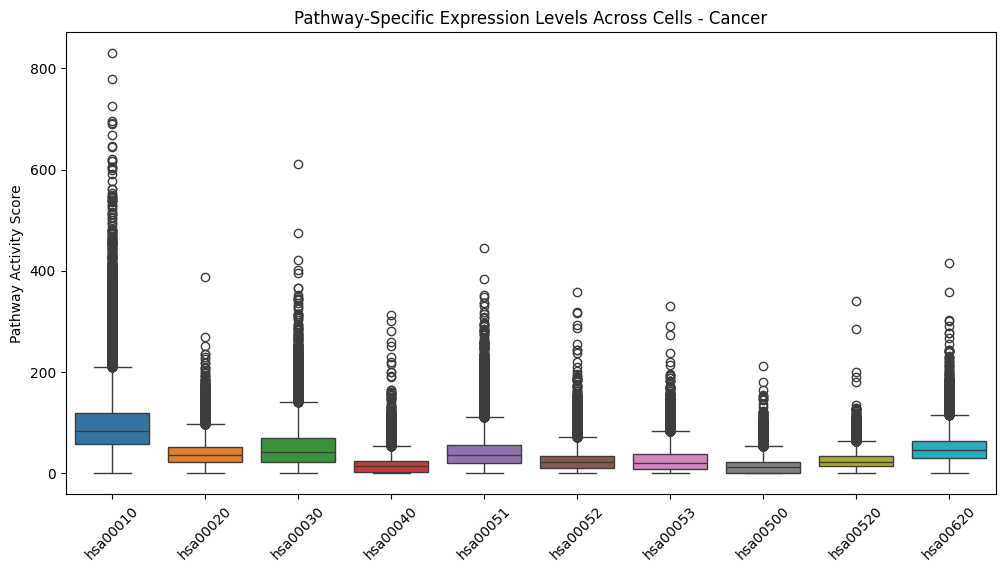

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of pathways to visualize
pathways_to_plot = pathway_activity_scores_healthy.columns[:10]  # Adjust the slice as needed

# Plotting for Healthy dataset
plt.figure(figsize=(12, 6))
sns.boxplot(data=pathway_activity_scores_healthy[pathways_to_plot])
plt.xticks(rotation=45)
plt.title('Pathway-Specific Expression Levels Across Cells - Healthy')
plt.ylabel('Pathway Activity Score')
plt.show()

# Plotting for Cancer dataset
plt.figure(figsize=(12, 6))
sns.boxplot(data=pathway_activity_scores_cancer[pathways_to_plot])
plt.xticks(rotation=45)
plt.title('Pathway-Specific Expression Levels Across Cells - Cancer')
plt.ylabel('Pathway Activity Score')
plt.show()


In [ ]:
# Example for a specific pathway in Healthy dataset
pathway_id = 'hsa00010'  # Example pathway ID

# Ranking cells by their expression level in the pathway for Healthy
ranked_cells_healthy = pathway_activity_scores_healthy[[pathway_id]].sort_values(by=pathway_id, ascending=False)
print("Ranked cells based on pathway expression in Healthy (Top 10):\n", ranked_cells_healthy.head(10))

# Example for a specific pathway in Cancer dataset
# Ranking cells by their expression level in the pathway for Cancer
ranked_cells_cancer = pathway_activity_scores_cancer[[pathway_id]].sort_values(by=pathway_id, ascending=False)
print("Ranked cells based on pathway expression in Cancer (Top 10):\n", ranked_cells_cancer.head(10))


Ranked cells based on pathway expression in Healthy (Top 10):
                            hsa00010
SRR8942434-AGGCACAGACAG  407.539471
SRR8942434-CCGACTCATCTC  327.946273
SRR8942434-TCTTCCGGACAT  324.844065
SRR8942434-TAGGGTAAGCGA  319.372200
SRR8942434-TTGACCGGAGGA  318.118371
SRR8942434-GCAGATCCGGAC  307.547594
SRR8942435-TATGAGTCCACG  300.480769
SRR8942434-ATATCCATAAGG  297.302356
SRR8942434-TAGCGCCAAGTG  292.112944
SRR8942434-AGAGGTCCGTAG  289.312458
Ranked cells based on pathway expression in Cancer (Top 10):
                              hsa00010
ERR2744031-CTCGAGGAGCGACG  830.242972
ERR2744036-ACTGAGTAGCTGAA  779.165721
ERR2744039-GTAGTCACATCAGT  724.971483
ERR2744038-GTATCTTCAGATCC  695.870690
ERR2744040-GGGCACTCACCACG  691.899152
ERR2744032-CACAGGCTCATTGC  690.856677
ERR2744039-GACCAATCATGCCA  667.985092
ERR2744040-CCCAGTTTCATCGG  645.882402
ERR2744033-AATCGAAGTGGCCC  644.040555
ERR2744039-CCTTCGATCCCTAA  620.689672


In [ ]:
# Define the list of pathway IDs for the query
pathways_list = ['hsa00010', 'hsa00020', 'hsa00030']

# For Healthy dataset
co_expressed_cells_above_healthy = coexpression_query(pathway_activity_scores_healthy, pathways_list, 80, 'above')
co_expressed_cells_below_healthy = coexpression_query(pathway_activity_scores_healthy, pathways_list, 20, 'below')

print("Healthy Co-Expressed Cells Above 80:\n", co_expressed_cells_above_healthy)
print("Healthy Co-Expressed Cells below 20:\n", co_expressed_cells_below_healthy)

# For Cancer dataset
co_expressed_cells_above_cancer = coexpression_query(pathway_activity_scores_cancer, pathways_list, 80, 'above')
co_expressed_cells_below_cancer = coexpression_query(pathway_activity_scores_cancer, pathways_list, 20, 'below')

print("Cancer Co-Expressed Cells Above 80:\n", co_expressed_cells_above_cancer)
print("Cancer Co-Expressed Cells below 20:\n", co_expressed_cells_below_cancer)

Healthy Co-Expressed Cells Above 80:
                            hsa00010    hsa00020    hsa00030   hsa00040  \
SRR8942434-AAAATGCTTTCT  134.566467  129.582526  110.099838  58.901148   
SRR8942434-AAAGGACACGAG   97.002615   93.409926   97.002615  46.704963   
SRR8942434-AAAGTACATATA  222.893668   95.394821  123.829815   0.000000   
SRR8942434-AAAGTACATATG  208.947519  102.433533  129.167559  43.900086   
SRR8942434-AAAGTACATATT  191.942096  105.618933  201.082196   0.000000   
...                             ...         ...         ...        ...   
SRR8942436-GTACGGCGGTTA  106.052052  136.165600  164.969862   0.000000   
SRR8942436-GTCGCACTATTA  102.746758   98.941322  102.746758  32.980441   
SRR8942436-TCCTAATGCGGC  145.320669   93.292281  193.760892   0.000000   
SRR8942436-TCCTACGGCCCA  188.263510  134.289472   97.618116   0.000000   
SRR8942436-TTAGTAGGGCTA  132.748059  102.265171  194.697153  51.132586   

                           hsa00051    hsa00052    hsa00053    hsa00500  

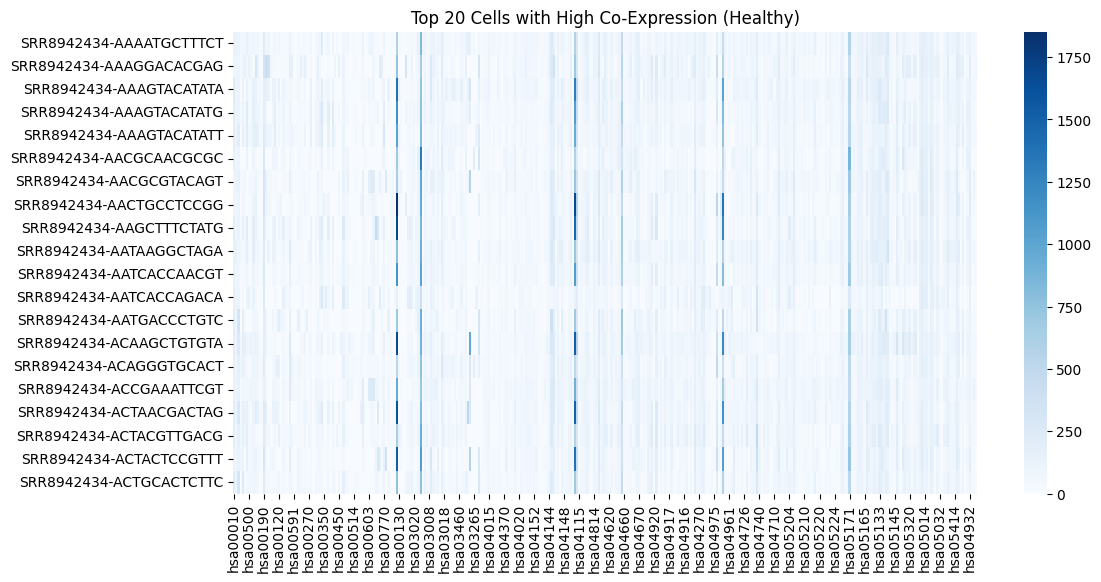

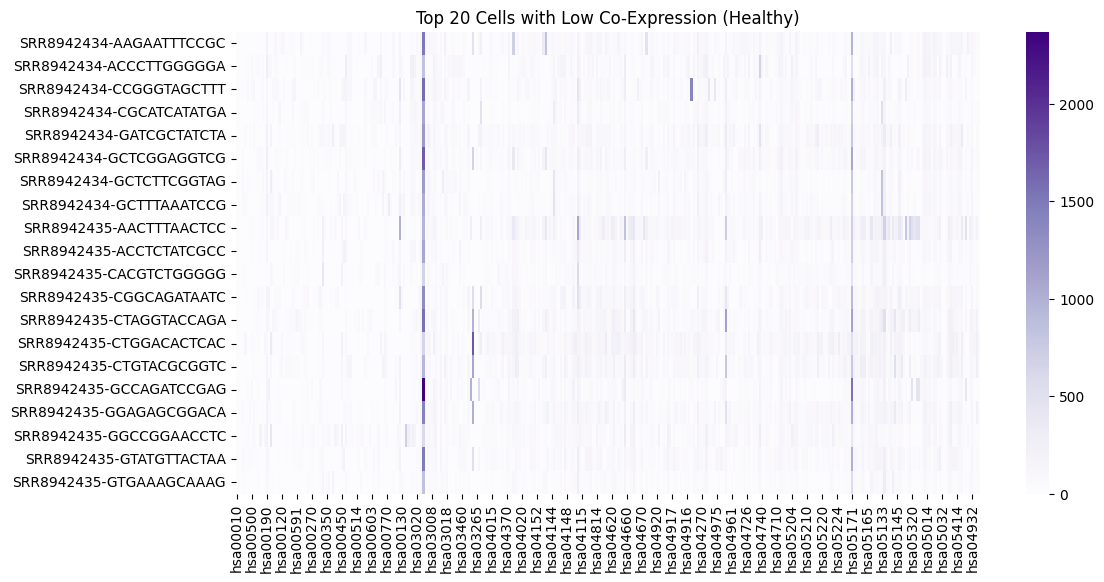

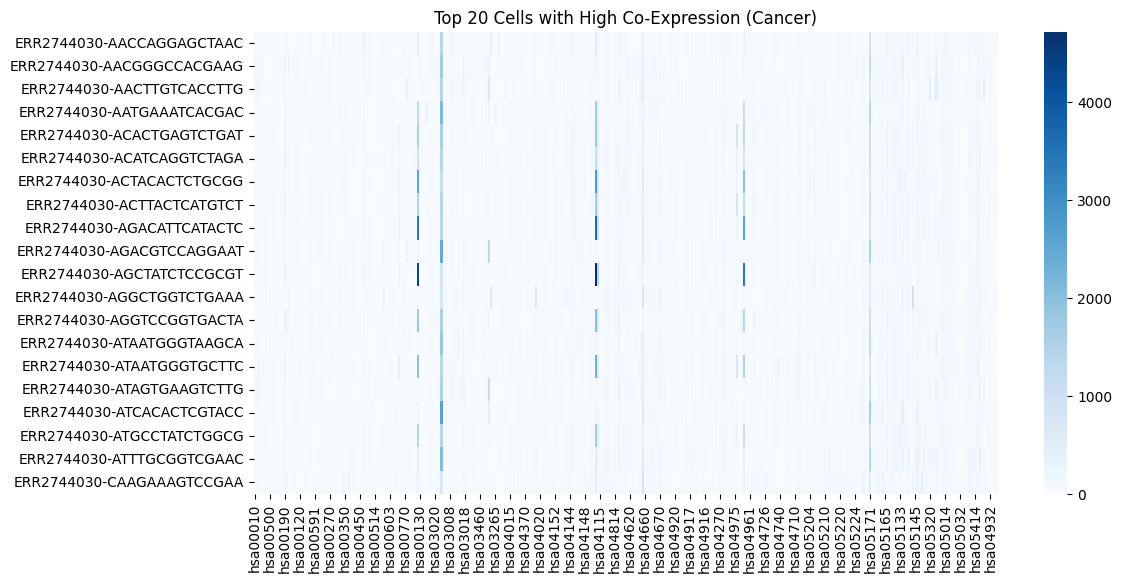

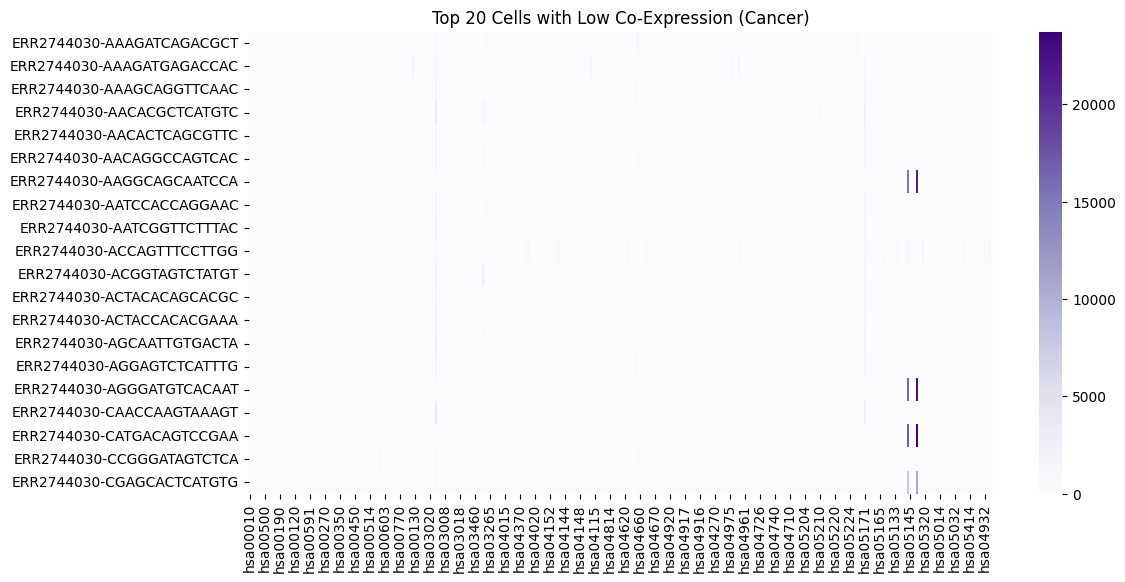

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization for Healthy dataset
# Displaying only the top 20 cells for each condition
plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_above_healthy.head(20), annot=False, cmap='Blues')
plt.title('Top 20 Cells with High Co-Expression (Healthy)')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_below_healthy.head(20), annot=False, cmap='Purples')
plt.title('Top 20 Cells with Low Co-Expression (Healthy)')
plt.show()

# Visualization for Cancer dataset
# Displaying only the top 20 cells for each condition
plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_above_cancer.head(20), annot=False, cmap='Blues')
plt.title('Top 20 Cells with High Co-Expression (Cancer)')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_below_cancer.head(20), annot=False, cmap='Purples')
plt.title('Top 20 Cells with Low Co-Expression (Cancer)')
plt.show()


# Clustering

In [10]:
pip install python-igraph louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.2 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import numpy as np

# Load your data
h5ad_path_healthy = "/content/drive/MyDrive/Colab Notebooks/Final_Pres_normalised_count.h5ad"
adata_healthy = sc.read_h5ad(h5ad_path_healthy)
adata_healthy = adata_healthy.transpose()

h5ad_path_cancer = "/content/drive/MyDrive/Colab Notebooks/Cancer_filtered_normalised_count.h5ad"
adata_cancer = sc.read_h5ad(h5ad_path_cancer)
adata_cancer = adata_cancer.transpose()

In [11]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

# Function to perform PCA, compute neighbors, and perform Louvain clustering
def process_adata(adata, label, resolution):
    # Perform PCA
    sc.tl.pca(adata, n_comps=10)

    # Compute the neighborhood graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

    # Perform Louvain clustering
    sc.tl.louvain(adata, resolution)  # Adjust the resolution parameter as needed

    # Check the clustering result
    print(f"Louvain clustering for {label}:")
    print(adata.obs['louvain'])

# Process healthy data
process_adata(adata_healthy, "Healthy", 1.0)

# Process cancer data
process_adata(adata_cancer, "Cancer", 1.0)


Louvain clustering for Healthy:
SRR8942434-AAAACACACTGG    10
SRR8942434-AAAACCGCTGGT     4
SRR8942434-AAAATGCTTTCT     9
SRR8942434-AAAATTCCGCAC     1
SRR8942434-AAAGGACACGAG     1
                           ..
SRR8942436-TTTTAGCGCTCA    12
SRR8942436-TTTTCTACCCTA     5
SRR8942436-TTTTGTAATATA     5
SRR8942436-TTTTTCGCGCGG     0
SRR8942436-TTTTTGGAGCCC     2
Name: louvain, Length: 2694, dtype: category
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']
Louvain clustering for Cancer:
ERR2744030-AAAACCGCATATGA     0
ERR2744030-AAAACCGCATTCTC     2
ERR2744030-AAAACCGGTACTTG     2
ERR2744030-AAAACCGGTTGCCT     7
ERR2744030-AAAATGATCAAGAA     0
                             ..
ERR2744041-TTTGTCAGTTCAGC     4
ERR2744041-TTTGTCAGTTCCCG    17
ERR2744041-TTTGTCATCGACAG     5
ERR2744041-TTTGTCATCTCGCT     5
ERR2744041-TTTGTCATCTGGGC     4
Name: louvain, Length: 32341, dtype: category
Categories (25, object): ['0', '1', '2', '3', ..., '21', '22', '23', '24']


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg_healthy = silhouette_score(adata_healthy.obsm['X_pca'][:, :10], adata_healthy.obs['louvain'])
print('The average silhouette score for healthy dataset is:', silhouette_avg_healthy)

silhouette_avg_cancer = silhouette_score(adata_cancer.obsm['X_pca'][:, :10], adata_cancer.obs['louvain'])
print('The average silhouette score for cancer dataset is:', silhouette_avg_cancer)

The average silhouette score for healthy dataset is: 0.23891048
The average silhouette score for cancer dataset is: 0.10436384


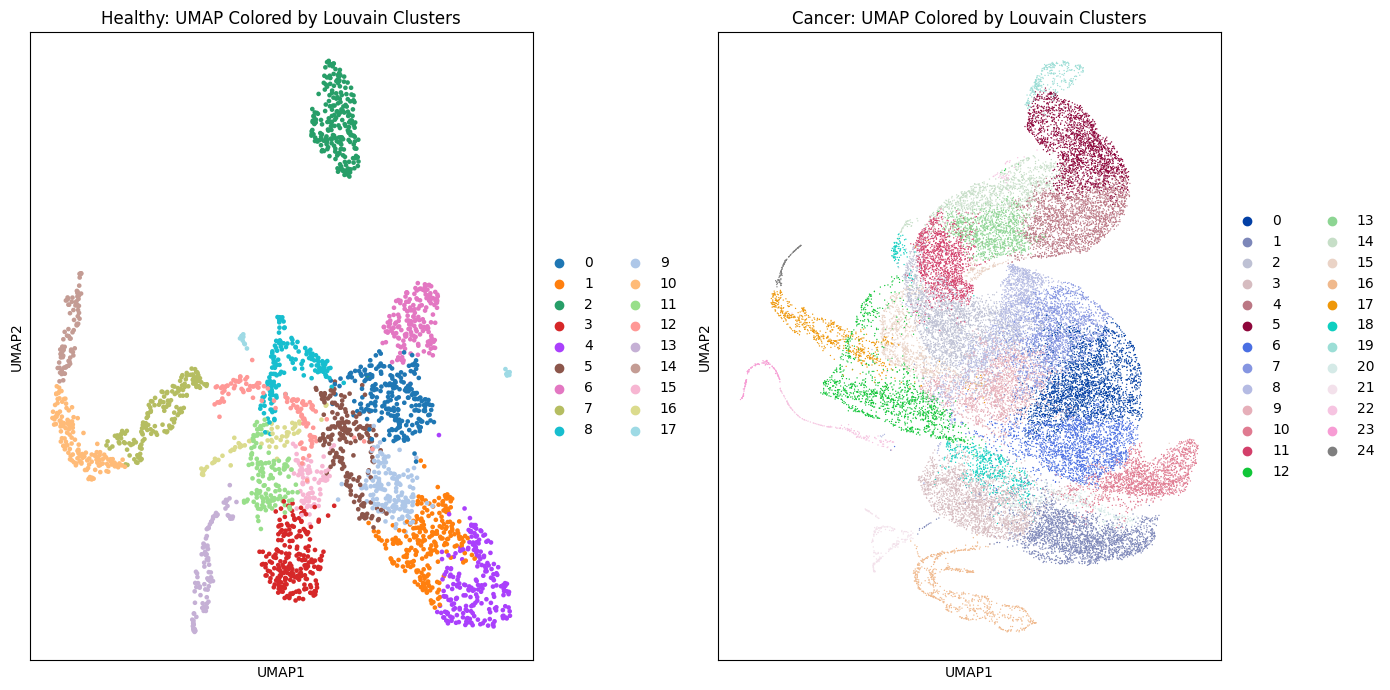

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Compute UMAP for healthy dataset
sc.tl.umap(adata_healthy)

# Compute UMAP for cancer dataset
sc.tl.umap(adata_cancer)

# Plotting UMAPs side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot UMAP for healthy data
sc.pl.umap(adata_healthy, color='louvain', title='Healthy: UMAP Colored by Louvain Clusters', ax=axes[0], show=False)

# Plot UMAP for cancer data
sc.pl.umap(adata_cancer, color='louvain', title='Cancer: UMAP Colored by Louvain Clusters', ax=axes[1], show=False)

plt.tight_layout()
plt.show()


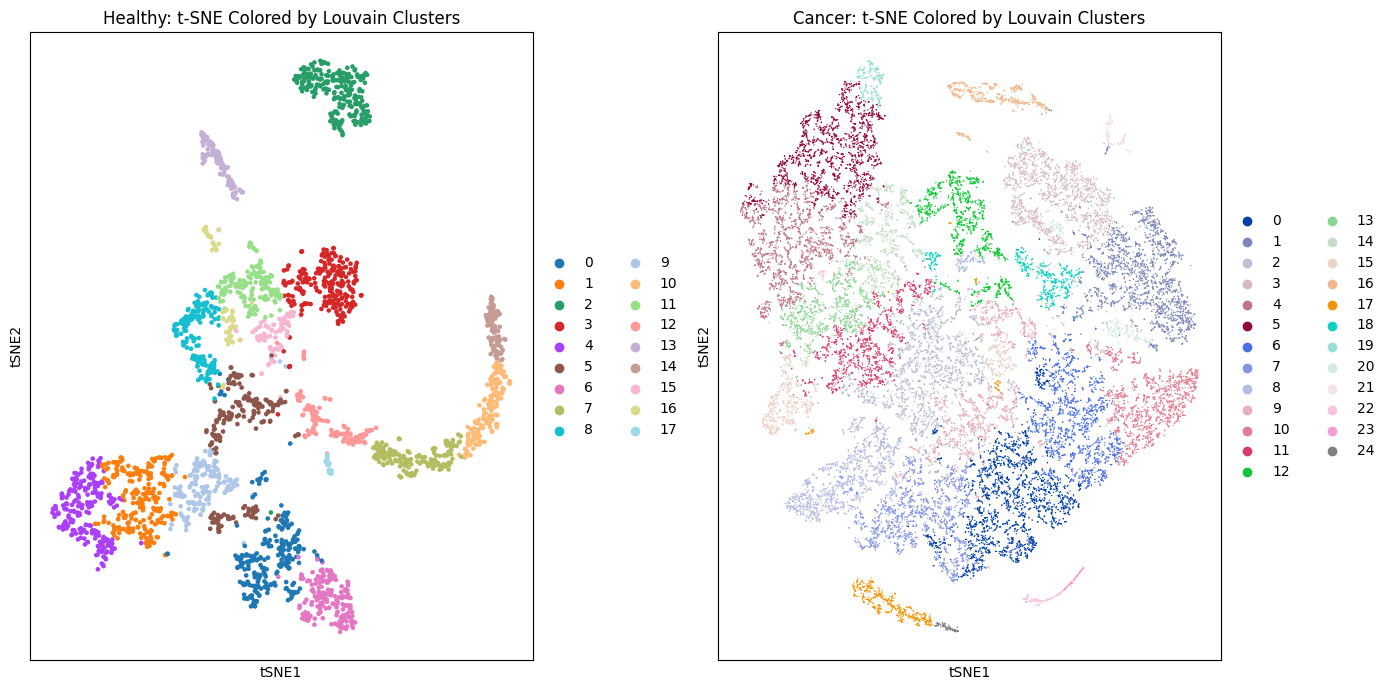

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Compute t-SNE for the healthy dataset
sc.tl.tsne(adata_healthy, n_pcs=10)  # if you changed PCA parameters, make sure it had at least 10 PCs

# Compute t-SNE for the cancer dataset
sc.tl.tsne(adata_cancer, n_pcs=10)  # if you changed PCA parameters, make sure it had at least 10 PCs

# Plotting t-SNEs side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot t-SNE for healthy data
sc.pl.tsne(adata_healthy, color='louvain', title='Healthy: t-SNE Colored by Louvain Clusters', ax=axes[0], show=False)

# Plot t-SNE for cancer data
sc.pl.tsne(adata_cancer, color='louvain', title='Cancer: t-SNE Colored by Louvain Clusters', ax=axes[1], show=False)

plt.tight_layout()
plt.show()


In [ ]:
# In case we want to get a specfied number of clusters, we can use this to get the corresponding resolution

import scanpy as sc
# Start with a guess for the resolution parameter
resolution = 0.675
cluster_count = 0

while True:
    # Run Louvain clustering with the current resolution
    sc.tl.louvain(adata_cancer, resolution=resolution)

    # Get the unique clusters
    unique_clusters = adata_cancer.obs['louvain'].unique()
    cluster_count = len(unique_clusters)
    print(resolution, cluster_count, number_of_clusters_cancer)

    # Check if we are close to the desired number of clusters
    if cluster_count > number_of_clusters_cancer:
        # Too many clusters, decrease resolution
        resolution -= 0.1
    elif cluster_count < number_of_clusters_cancer:
        # Too few clusters, increase resolution
        resolution += 0.1
    else:
        # We have the desired number of clusters
        break

    # Avoid infinite loop in case we can't find the exact number
    if resolution <= 0 or resolution > 10:
        break

print(f'Resolved with {cluster_count} clusters at a resolution of {resolution}')


0.675 20 40
0.775 25 40
0.875 24 40
0.975 27 40
1.075 28 40
1.175 30 40
1.2750000000000001 33 40
1.3750000000000002 35 40
1.4750000000000003 38 40
1.5750000000000004 40 40
Resolved with 40 clusters at a resolution of 1.5750000000000004


In [ ]:
# In case we want to get a specfied number of clusters, we can use this to get the corresponding resolution

import scanpy as sc
# Start with a guess for the resolution parameter
resolution = 3.475
cluster_count = 0

while True:
    # Run Louvain clustering with the current resolution
    sc.tl.louvain(adata_healthy, resolution=resolution)

    # Get the unique clusters
    unique_clusters = adata_healthy.obs['louvain'].unique()
    cluster_count = len(unique_clusters)
    print(resolution, cluster_count, number_of_clusters_healthy)

    # Check if we are close to the desired number of clusters
    if cluster_count > number_of_clusters_healthy:
        # Too many clusters, decrease resolution
        resolution -= 0.1
    elif cluster_count < number_of_clusters_healthy:
        # Too few clusters, increase resolution
        resolution += 0.1
    else:
        # We have the desired number of clusters
        break

    # Avoid infinite loop in case we can't find the exact number
    if resolution <= 0 or resolution > 10:
        break

print(f'Resolved with {cluster_count} clusters at a resolution of {resolution}')


3.475 40 20
3.375 38 20
3.275 37 20
3.175 35 20
3.0749999999999997 34 20
2.9749999999999996 34 20
2.8749999999999996 35 20
2.7749999999999995 33 20
2.6749999999999994 34 20
2.5749999999999993 30 20
2.474999999999999 30 20
2.374999999999999 29 20
2.274999999999999 29 20
2.174999999999999 28 20
2.074999999999999 27 20
1.9749999999999988 27 20
1.8749999999999987 26 20
1.7749999999999986 26 20
1.6749999999999985 24 20
1.5749999999999984 22 20
1.4749999999999983 22 20
1.3749999999999982 22 20
1.2749999999999981 22 20
1.174999999999998 20 20
Resolved with 20 clusters at a resolution of 1.174999999999998
